In [1]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
## Train the data

#import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator

# img_size = (224, 224)
# batch_size = 32

# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_data = datagen.flow_from_directory(
#     train_dir, target_size=img_size, batch_size=batch_size, subset='training')

# val_data = datagen.flow_from_directory(
#     train_dir, target_size=img_size, batch_size=batch_size, subset='validation')

# test_data = datagen.flow_from_directory(
#     test_dir, target_size=img_size, batch_size=batch_size)

 


In [2]:
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from os.path import exists
from collections import defaultdict

def load_data(file_path, base_dir, max_per_class=None):
    image_paths = defaultdict(list)
    labels = []
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.split('/')
            class_name = parts[0].strip()
            img_path = f"{base_dir}/{class_name}/{parts[1].strip()}"
            image_paths[class_name].append(img_path)
    
    # Restrict the number of images per class
    final_image_paths = []
    final_labels = []
    for class_name, paths in image_paths.items():
        if max_per_class:
            paths = paths[:max_per_class]  # Limit to max_per_class images
        final_image_paths.extend(paths)
        final_labels.extend([class_name] * len(paths))
    
    return final_image_paths, final_labels

def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in image_paths:
        img_path = img_path + '.jpg'
        if not exists(img_path):
            print(f"Image path does not exist: {img_path}")
            continue
        img = Image.open(img_path)
        img = img.convert('RGB')  # Ensure all images are in RGB mode
        img = img.resize(target_size)
        img_array = np.array(img)
        
        # Check if the image shape is correct
        if img_array.shape != (target_size[0], target_size[1], 3):
            print(f"Unexpected image shape: {img_array.shape} for image {img_path}")
            continue
        
        images.append(img_array)
    return np.array(images)

# Load training and testing data with fewer files per class
train_image_paths, train_labels = load_data(
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/meta/train.txt',
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images',
    max_per_class=130  # Take at most 50 images per class
)
test_image_paths, test_labels = load_data(
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/meta/test.txt',
    '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images',
    max_per_class=40  # Take at most 20 images per class
)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Preprocess images
print('train_image_paths:', train_image_paths)
train_images = load_and_preprocess_images(train_image_paths)
test_images = load_and_preprocess_images(test_image_paths)

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert to NumPy arrays for model input
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels_encoded = np.array(train_labels_encoded)
test_labels_encoded = np.array(test_labels_encoded)

print(f"Classes: {label_encoder.classes_}")


train_image_paths: ['/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1005649', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1014775', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1026328', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1028787', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1043283', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1050519', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1057749', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_FoodClassification/food-101/images/apple_pie/1057810', '/Users/aariziqbal/Desktop/Homework/ECS_174/project/ECS_174_

In [3]:
## using the data in a Tensorflow tensor
import tensorflow as tf
# Define a data augmentation function
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
    image = tf.image.random_crop(image, size=[224, 224, 3])  # Random crop (adjust size as needed)
    return image, label

# Apply data augmentation to the training dataset
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels_encoded))
    .map(lambda x, y: (tf.image.resize(x, [224, 224]), y))  # Resize images to 224x224
    .map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Preprocess the test dataset (no augmentation for testing)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_labels_encoded))
    .map(lambda x, y: (tf.image.resize(x, [224, 224]), y))  # Resize images to 224x224
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


Epoch 1/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 245s 568ms/step - accuracy: 0.0473 - loss: 5.2155 - val_accuracy: 0.0099 - val_loss: 8.1966 - learning_rate: 0.0010
Epoch 2/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 235s 568ms/step - accuracy: 0.0507 - loss: 4.9709 - val_accuracy: 0.0099 - val_loss: 4.9964 - learning_rate: 0.0010
Epoch 3/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 235s 568ms/step - accuracy: 0.0481 - loss: 4.9501 - val_accuracy: 0.0131 - val_loss: 4.7695 - learning_rate: 0.0010
Epoch 4/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 238s 575ms/step - accuracy: 0.0474 - loss: 4.8227 - val_accuracy: 0.0111 - val_loss: 4.9396 - learning_rate: 0.0010
Epoch 5/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 233s 564ms/step - accuracy: 0.0405 - loss: 4.8011 - val_accuracy: 0.0109 - val_loss: 4.8464 - learning_rate: 0.0010
Epoch 6/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 261s 632ms/step - accuracy: 0.0225 - loss: 4.7878 - val_accuracy: 0.0139 - val_loss: 4.6382 - learning_rate: 5.0000e-04
Epoch 7/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 235s 568ms/step - ac

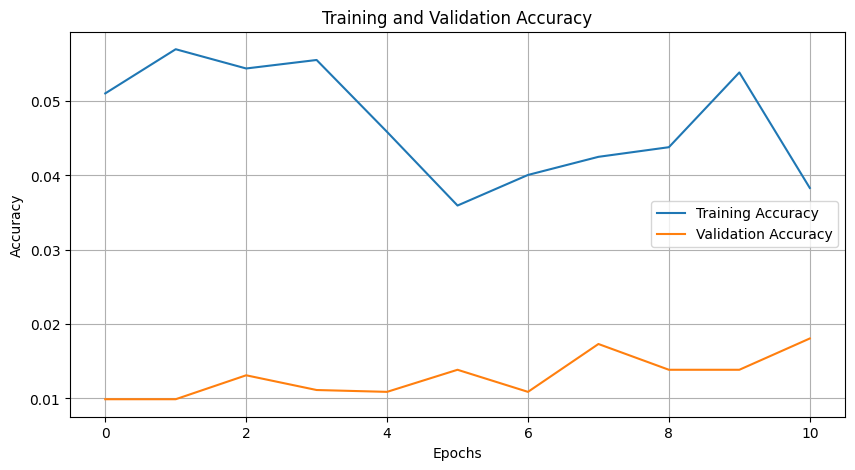

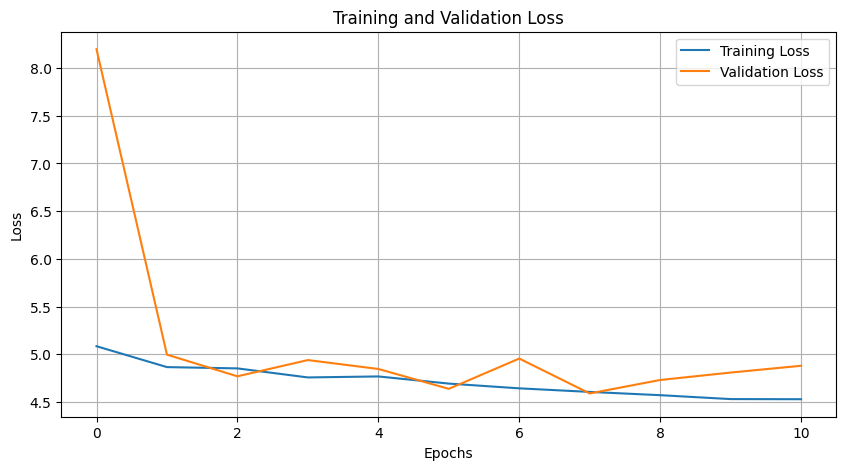

In [4]:
import tensorflow as tf
from tensorflow.keras import optimizers, models, callbacks
import matplotlib.pyplot as plt

def create_model():
    # Load pre-trained EfficientNetB0
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze earlier layers
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    # Create the model
    model = models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(101, activation='softmax')
    ])
    
    return model


model = create_model()

# Define callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

model.compile(
    optimizer=optimizers.AdamW(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_improved = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Save training history
train_acc = history_improved.history['accuracy']
val_acc = history_improved.history['val_accuracy']
train_loss = history_improved.history['loss']
val_loss = history_improved.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
